In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Jul 30 12:05:25 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install transformers

In [5]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
import torch.nn.functional as F
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
import sklearn.utils
import time
import re
from google.colab import runtime

In [6]:
# Retrive the data from stored dataset
dataDir = "/content/drive/MyDrive/WoS/data/46985"
tsvData = os.path.join(dataDir,"WoSDataset_46985.tsv")

tsvData = np.loadtxt(tsvData, dtype=str, delimiter="\t")
print(np.shape(tsvData))

(46985, 4)


In [7]:
print(tsvData[0:10])

[['0' 'CS'
  ' 21dimensional nonlinear optical waves erbiumdoped optical fibre symbolic computation soliton solution soliton interaction        '
  '2  1dimensional nonlinear optical waves through the coherently excited resonant medium doped with the erbium atoms can be described by a 2  1dimensional nonlinear schrodinger equation coupled with the selfinduced transparency equations for such a system via the hirota method and symbolic computation linear forms one twoand nsoliton solutions are obtained asymptotic analysis is conducted and suggests that the interaction between the two solitons is elastic bright solitons are obtained for the fields e and p while the dark ones for the field n with e as the electric field p as the polarization in the resonant medium induced by the electric field and n as the population inversion profile of the dopant atoms headon interaction between the bidirectional two solitons and overtaking interaction between the unidirectional two solitons are seen inf

In [8]:
allLabels = tsvData[:,0]
domains = tsvData[:,1]
keywords = tsvData[:,2]
abstracts = tsvData[:,3]

In [9]:
labels = np.unique(domains, return_counts=True)[0]
labelCounts=  np.unique(domains, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

Labels  ['CS' 'Civil' 'ECE' 'MAE' 'Medical' 'Psychology' 'biochemistry']
Label counts  [ 6514  4237  5483  3297 14625  7142  5687]


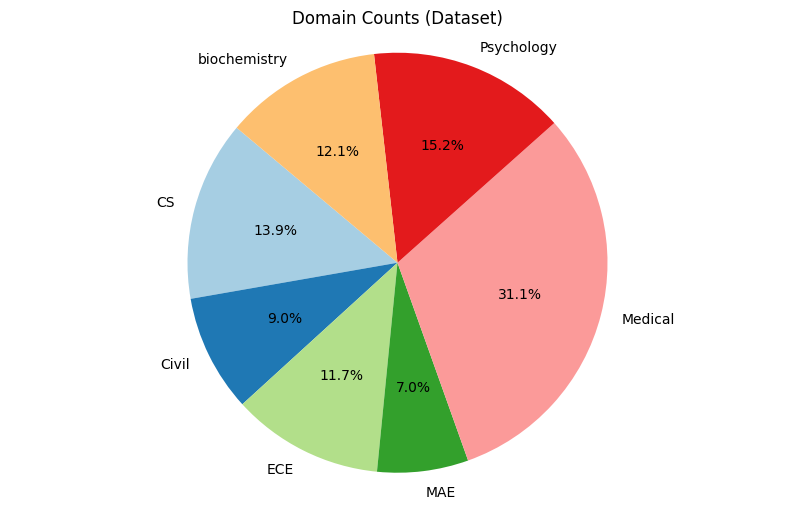

The domain CS has 6514 records in the dataset.
The domain Civil has 4237 records in the dataset.
The domain ECE has 5483 records in the dataset.
The domain MAE has 3297 records in the dataset.
The domain Medical has 14625 records in the dataset.
The domain Psychology has 7142 records in the dataset.
The domain biochemistry has 5687 records in the dataset.


In [10]:
# Visualize domain counts in dataset
plt.figure(figsize=(10, 6))
plt.title("Domain Counts (Dataset)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')
plt.show()

for i, domain in enumerate(labels):
    print("The domain", domain, "has", labelCounts[i], "records in the dataset.")

In [11]:
# Shuffle data
dataShuffled = sklearn.utils.shuffle(tsvData)

abstractsShuffled = dataShuffled[:,3]
keywordsShuffled = dataShuffled[:,2]
domainsShuffled = dataShuffled[:,1]
allLabelsShuffled = dataShuffled[:,0]

print("Number of abstracts: ", len(abstractsShuffled))
print("Shape of abstracts: ", np.shape(abstractsShuffled))
print(abstractsShuffled[0:2])

print("Number of keywords: ", len(keywordsShuffled))
print("Shape of keywords: ", np.shape(keywordsShuffled))
print(abstractsShuffled[0:2])

print("Number of domains: ", len(domainsShuffled))
print("Shape of domains: ", np.shape(domainsShuffled))
print(domainsShuffled[0:2])

print("Number of labels: ", len(allLabelsShuffled))
print("Shape of labels: ", np.shape(allLabelsShuffled))
print(allLabelsShuffled[0:2])


# Convert labels to integer
allLabelsDigitShuffled = allLabelsShuffled.astype(int)

print(abstractsShuffled[0:10])
print(keywordsShuffled[0:10])
print(domainsShuffled[0:10])
print(allLabelsShuffled[0:10])
print(allLabelsDigitShuffled[0:10])

Number of abstracts:  46985
Shape of abstracts:  (46985,)
['objectives to investigate safety tolerability and efficacy of longterm 52 weeks openlabel treatment with mirabegron 50 mg with an optional dose increase to 100 mg in patients with overactive bladder oab methods patients received mirabegron 50 mg once daily for 52 weeks if efficacy was insufficient at week 8 the dose could be increased to 100 mg safety was evaluated based on vital signs adverse events aes laboratory findings electrocardiogram and postvoid residual volume treatment efficacy was assessed with a 3day micturition diary and the kings health questionnaire khq results two hundred and four patients were enrolled mirabegron dose was maintained at 50mg in 153 patients and increased to 100 mg in 50 patients mirabegron was well tolerated at both doses incidences of aes and treatmentrelated aes were 914 and 336 in patients on 50 mg and 100 and 300 in patients on 100 mg respectively time course changes in systolic or diastol

In [12]:
# Split dataset into training and testing (80/20 split)
train_data, test_data = train_test_split(dataShuffled, test_size=0.2, random_state=42)
print(np.shape(train_data))
print(np.shape(test_data))

# Further split training data into training and validation (80/20 split of training set)
_, val_data = train_test_split(test_data, test_size=0.2, random_state=42)
print(np.shape(train_data))
print(np.shape(test_data))
print(np.shape(val_data))
# Load SciBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

(37588, 4)
(9397, 4)
(37588, 4)
(9397, 4)
(1880, 4)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

In [13]:
abstractsTrain = train_data[:,3]
keywordsTrain = train_data[:,2]
domainsTrain = train_data[:,1]
allLabelsTrain = train_data[:,0]

print("Number of abstracts: ",len(abstractsTrain))
print("Shape of abstracts: ",np.shape(abstractsTrain))
print("Number of keywords: ",len(keywordsTrain))
print("Shape of keywords: ",np.shape(keywordsTrain))
print("Number of domains: ",len(domainsTrain))
print("Shape of domains: ",np.shape(domainsTrain))
print("Number of labels: ",len(allLabelsTrain))
print("Shape of labels: ",np.shape(allLabelsTrain))

print(abstractsTrain[0:2])
print(keywordsTrain[0:2])
print(domainsTrain[0:2])
print(allLabelsTrain[0:2])

Number of abstracts:  37588
Shape of abstracts:  (37588,)
Number of keywords:  37588
Shape of keywords:  (37588,)
Number of domains:  37588
Shape of domains:  (37588,)
Number of labels:  37588
Shape of labels:  (37588,)
['to explore the putative correlation between themultilocus sequence types mlst and antifungal susceptibility of clinical candida tropicalis isolates in mainland china eightytwo clinical c tropicalis isolates were collected from sixtynine patients at ruijin hospital shanghai jiao tong university school of medicine shanghai china from july 2012 to february 2015 and antifungal susceptibility tests were performed genetic profiles of those 82 isolates 30 azoleresistant and 52 azolesusceptible were characterised by multilocus sequence typing phylogenetic analysis of the data was conducted with the clustering method using upgma unweighted pair group method with arithmetic averages and the minimal spanning tree algorithm mlst clonal clusters were analysed using the eburst v3 p

Labels  ['CS' 'Civil' 'ECE' 'MAE' 'Medical' 'Psychology' 'biochemistry']
Label counts  [ 5192  3376  4417  2628 11738  5680  4557]


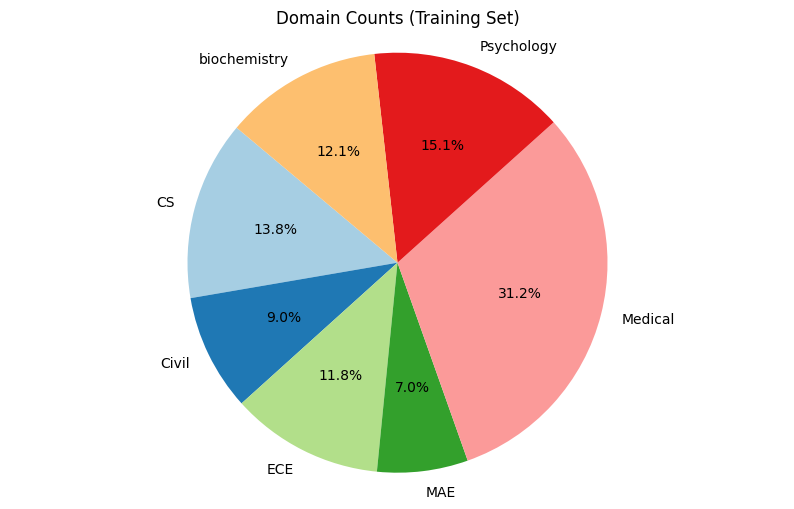

The domain CS has 5192 records in the training set.
The domain Civil has 3376 records in the training set.
The domain ECE has 4417 records in the training set.
The domain MAE has 2628 records in the training set.
The domain Medical has 11738 records in the training set.
The domain Psychology has 5680 records in the training set.
The domain biochemistry has 4557 records in the training set.


In [14]:
labels = np.unique(domainsTrain, return_counts=True)[0]
labelCounts =  np.unique(domainsTrain, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

nAbstract = len(abstractsTrain)
plt.figure(figsize=(10, 6))
plt.title("Domain Counts (Training Set)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

for i, domain in enumerate(labels):
    print("The domain", domain, "has", labelCounts[i], "records in the training set.")

In [15]:
abstractsTest = test_data[:,3]
keywordsTest = test_data[:,2]
domainsTest = test_data[:,1]
allLabelsTest = test_data[:,0]

print("Number of abstracts: ",len(abstractsTest))
print("Shape of abstracts: ",np.shape(abstractsTest))
print("Number of keywords: ",len(keywordsTest))
print("Shape of keywords: ",np.shape(keywordsTest))
print("Number of domains: ",len(domainsTest))
print("Shape of domains: ",np.shape(domainsTest))
print("Number of labels: ",len(allLabelsTest))
print("Shape of labels: ",np.shape(allLabelsTest))

# arr = np.array(domainsTest)
# cleaned_domains = np.char.strip(arr)
# print("Cleaned arr ", cleaned_domains)
# domainsLabelsTest = cleaned_domains
# print("Labels domains ", domainsLabelsTest)

print(abstractsTest[0:2])
print(keywordsTest[0:2])
print(domainsTest[0:2])
print(allLabelsTest[0:2])

Number of abstracts:  9397
Shape of abstracts:  (9397,)
Number of keywords:  9397
Shape of keywords:  (9397,)
Number of domains:  9397
Shape of domains:  (9397,)
Number of labels:  9397
Shape of labels:  (9397,)
['objective to propose a phylogenetic significance to the moro reflex which remains unexplained since its publication in 1918 because both hands are free at the end of the gesture method among the 75 videos of healthy term newborns we have filmed in a research project on antenatal education to parenthood we describe a sequence that clearly showed the successive movements of the moro reflex and we report the occurrence of this reflex in the videos that were recorded from time 0 of birth defined as the moment that lies between the birth of the thorax and the pelvis of the infant results the selected sequence showed the following succession of the newborns actions quick extensionadduction of both arms the orientation of the body head and eyes towards a human person and full extens

Labels  ['CS' 'Civil' 'ECE' 'MAE' 'Medical' 'Psychology' 'biochemistry']
Label counts  [1322  861 1066  669 2887 1462 1130]


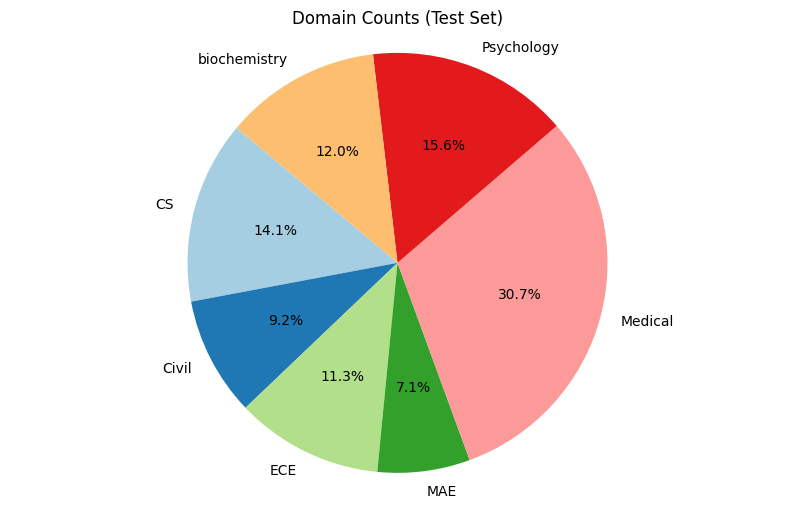

The domain CS has 1322 records in the test set.
The domain Civil has 861 records in the test set.
The domain ECE has 1066 records in the test set.
The domain MAE has 669 records in the test set.
The domain Medical has 2887 records in the test set.
The domain Psychology has 1462 records in the test set.
The domain biochemistry has 1130 records in the test set.


In [16]:
labels = np.unique(domainsTest, return_counts=True)[0]
labelCounts =  np.unique(domainsTest, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

nAbstract = len(abstractsTest)
plt.figure(figsize=(10, 6))
plt.title("Domain Counts (Test Set)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

for i, domain in enumerate(labels):
    print("The domain", domain, "has", labelCounts[i], "records in the test set.")

In [17]:
abstractsVal = val_data[:,3]
keywordsVal = val_data[:,2]
domainsVal = val_data[:,1]
allLabelsVal = val_data[:,0]

print("Number of abstracts: ",len(abstractsVal))
print("Shape of abstracts: ",np.shape(abstractsVal))
print("Number of keywords: ",len(keywordsVal))
print("Shape of keywords: ",np.shape(keywordsVal))
print("Number of domains: ",len(domainsVal))
print("Shape of domains: ",np.shape(domainsVal))
print("Number of labels: ",len(allLabelsVal))
print("Shape of labels: ",np.shape(allLabelsVal))

print(abstractsVal[0:2])
print(keywordsVal[0:2])
print(domainsVal[0:2])
print(allLabelsVal[0:2])

Number of abstracts:  1880
Shape of abstracts:  (1880,)
Number of keywords:  1880
Shape of keywords:  (1880,)
Number of domains:  1880
Shape of domains:  (1880,)
Number of labels:  1880
Shape of labels:  (1880,)
['the consistent depth positioning of seeds is vital for achieving the optimum yield of agricultural crops in stateoftheart seeding machines the depth of drill coulters will vary with changes in soil resistance this paper presents the retrofitting of an angle sensor to the pivoting point of a drill coulter providing sensor feedback to a control system that via an electrohydraulic actuator delivers a constant coulter depth the results showed a strong correlation between the angle of the coulter and the coulter depth under static r2  100 and dynamic r2  099 operations verified by a submillimetre accurate positioning system igps nikon metrology nv belgium mounted on the drill coulter at a drill coulter depth of 55 mm and controlled by an ordinary fixed spring loaded down force the

Labels  ['CS' 'Civil' 'ECE' 'MAE' 'Medical' 'Psychology' 'biochemistry']
Label counts  [264 166 210 143 590 286 221]


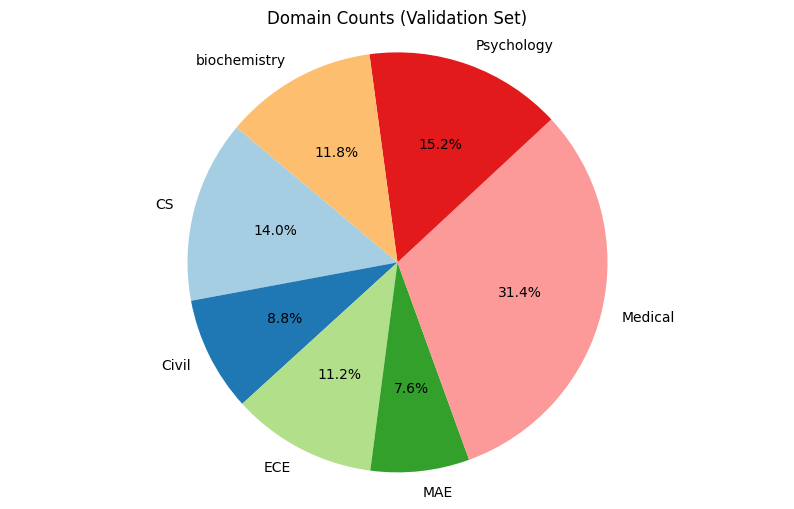

The domain CS has 264 records in the vaidation set.
The domain Civil has 166 records in the vaidation set.
The domain ECE has 210 records in the vaidation set.
The domain MAE has 143 records in the vaidation set.
The domain Medical has 590 records in the vaidation set.
The domain Psychology has 286 records in the vaidation set.
The domain biochemistry has 221 records in the vaidation set.


In [18]:
labels = np.unique(domainsVal, return_counts=True)[0]
labelCounts =  np.unique(domainsVal, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

nAbstract = len(abstractsVal)
plt.figure(figsize=(10, 6))
plt.title("Domain Counts (Validation Set)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

for i, domain in enumerate(labels):
    print("The domain", domain, "has", labelCounts[i], "records in the vaidation set.")

In [19]:
# Function to tokenize and encode the dataset
def encode_data(data, tokenizer, max_length=128):
    # print(len(data[:,2]))
    inputs = tokenizer(
        data[:,3].tolist(), # abstracts 3
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors="pt"
    )
    # print(len(dataShuffled[:, 0]))
    labels = torch.tensor(data[:, 0].astype(int))
    print("Label length ", len(labels))
    return TensorDataset(inputs['input_ids'], inputs['attention_mask'], labels)

In [20]:
print(np.shape(train_data))
print(np.shape(test_data))
print(np.shape(val_data))


(37588, 4)
(9397, 4)
(1880, 4)


In [21]:
# Encode training, validation, and testing data
train_dataset = encode_data(train_data, tokenizer)
val_dataset = encode_data(val_data, tokenizer)
test_dataset = encode_data(test_data, tokenizer)



# Data loaders
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=32)
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=32)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=32)

Label length  37588
Label length  1880
Label length  9397


In [22]:
# Load SciBERT model
print(len(np.unique(train_data[:,0])))
model = AutoModelForSequenceClassification.from_pretrained("allenai/scibert_scivocab_uncased", num_labels=len(np.unique(train_data[:,0])))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

7


pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [23]:
model.config

BertConfig {
  "_name_or_path": "allenai/scibert_scivocab_uncased",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.42.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 31090
}

In [24]:
# Optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
total_steps = len(train_dataloader) * 20
num_warmup_steps = 1e-4
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [25]:
def calculate_metrics(valType, predictions, true_labels):
    # Confusion matrix
    if(valType == 'test'):
        cm = confusion_matrix(true_labels, predictions)
        print("Confusion Matrix:\n", cm)

        # Classification report (includes precision, recall, F1 score)
        report = classification_report(true_labels, predictions, target_names=[str(i) for i in range(len(np.unique(true_labels)))])
        print("\nClassification Report:\n", report)

        # Calculate different types of F1 scores, precision, and recall
        f1_macro = f1_score(true_labels, predictions, average='macro')
        f1_micro = f1_score(true_labels, predictions, average='micro')
        f1_weighted = f1_score(true_labels, predictions, average='weighted')

        precision_macro = precision_score(true_labels, predictions, average='macro')
        precision_micro = precision_score(true_labels, predictions, average='micro')
        precision_weighted = precision_score(true_labels, predictions, average='weighted')

        recall_macro = recall_score(true_labels, predictions, average='macro')
        recall_micro = recall_score(true_labels, predictions, average='micro')
        recall_weighted = recall_score(true_labels, predictions, average='weighted')

        print(f"Macro F1 Score: {f1_macro}")
        print(f"Micro F1 Score: {f1_micro}")
        print(f"Weighted F1 Score: {f1_weighted}")

        print(f"Macro Precision: {precision_macro}")
        print(f"Micro Precision: {precision_micro}")
        print(f"Weighted Precision: {precision_weighted}")

        print(f"Macro Recall: {recall_macro}")
        print(f"Micro Recall: {recall_micro}")
        print(f"Weighted Recall: {recall_weighted}")

    elif(valType == 'val'):
        cm = confusion_matrix(true_labels, predictions)
        f1_macro = f1_score(true_labels, predictions, average='macro')
        f1_micro = f1_score(true_labels, predictions, average='micro')
        f1_weighted = f1_score(true_labels, predictions, average='weighted')

        precision_macro = precision_score(true_labels, predictions, average='macro')
        precision_micro = precision_score(true_labels, predictions, average='micro')
        precision_weighted = precision_score(true_labels, predictions, average='weighted')

        recall_macro = recall_score(true_labels, predictions, average='macro')
        recall_micro = recall_score(true_labels, predictions, average='micro')
        recall_weighted = recall_score(true_labels, predictions, average='weighted')
        # print('Val Micro F1:', f1_micro)
        return f1_micro

In [26]:
epochs = 20
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    start_time = time.time()

    # Training
    for step, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs}", unit="batch")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, labels = batch


        model.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=input_mask, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)

    # Validation
    model.eval()
    predictions = []
    true_labels = []

    for batch in val_dataloader:
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, labels = batch

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=input_mask)
            logits = outputs.logits

        logits = logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()

        batch_predictions = np.argmax(logits, axis=1)
        predictions.extend(batch_predictions)
        true_labels.extend(label_ids)

    val_micro_f1 = calculate_metrics('val', predictions, true_labels)
    elapsed_time = time.time() - start_time

    # Print epoch summary
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"  Train Loss: {avg_train_loss}")
    print(f"  Val Micro F1: {val_micro_f1}")
    print(f"  Time: {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")

Epoch 1/20: 100%|██████████| 1175/1175 [13:10<00:00,  1.49batch/s]


Epoch 1/20
  Train Loss: 0.5584391588226277
  Val Micro F1: 0.8622340425531915
  Time: 13m 24s


Epoch 2/20: 100%|██████████| 1175/1175 [13:09<00:00,  1.49batch/s]


Epoch 2/20
  Train Loss: 0.32967542683190487
  Val Micro F1: 0.8739361702127659
  Time: 13m 22s


Epoch 3/20: 100%|██████████| 1175/1175 [13:11<00:00,  1.48batch/s]


Epoch 3/20
  Train Loss: 0.22376995940474753
  Val Micro F1: 0.8712765957446809
  Time: 13m 25s


Epoch 4/20: 100%|██████████| 1175/1175 [13:11<00:00,  1.48batch/s]


Epoch 4/20
  Train Loss: 0.14570364224546134
  Val Micro F1: 0.8675531914893617
  Time: 13m 24s


Epoch 5/20: 100%|██████████| 1175/1175 [13:11<00:00,  1.48batch/s]


Epoch 5/20
  Train Loss: 0.09283258687585909
  Val Micro F1: 0.8707446808510638
  Time: 13m 24s


Epoch 6/20: 100%|██████████| 1175/1175 [13:11<00:00,  1.48batch/s]


Epoch 6/20
  Train Loss: 0.06347714311906454
  Val Micro F1: 0.8723404255319149
  Time: 13m 24s


Epoch 7/20: 100%|██████████| 1175/1175 [13:11<00:00,  1.48batch/s]


Epoch 7/20
  Train Loss: 0.04102350584189209
  Val Micro F1: 0.872872340425532
  Time: 13m 24s


Epoch 8/20: 100%|██████████| 1175/1175 [13:10<00:00,  1.49batch/s]


Epoch 8/20
  Train Loss: 0.030871714686174837
  Val Micro F1: 0.8638297872340426
  Time: 13m 23s


Epoch 9/20: 100%|██████████| 1175/1175 [13:10<00:00,  1.49batch/s]


Epoch 9/20
  Train Loss: 0.02007709194159264
  Val Micro F1: 0.8696808510638298
  Time: 13m 23s


Epoch 10/20: 100%|██████████| 1175/1175 [13:11<00:00,  1.48batch/s]


Epoch 10/20
  Train Loss: 0.01567533726348205
  Val Micro F1: 0.8659574468085106
  Time: 13m 24s


Epoch 11/20: 100%|██████████| 1175/1175 [13:10<00:00,  1.49batch/s]


Epoch 11/20
  Train Loss: 0.01309782217378094
  Val Micro F1: 0.8638297872340426
  Time: 13m 24s


Epoch 12/20: 100%|██████████| 1175/1175 [13:10<00:00,  1.49batch/s]


Epoch 12/20
  Train Loss: 0.011809234620338836
  Val Micro F1: 0.8648936170212765
  Time: 13m 23s


Epoch 13/20: 100%|██████████| 1175/1175 [13:09<00:00,  1.49batch/s]


Epoch 13/20
  Train Loss: 0.0074550594900164415
  Val Micro F1: 0.8632978723404255
  Time: 13m 22s


Epoch 14/20: 100%|██████████| 1175/1175 [13:09<00:00,  1.49batch/s]


Epoch 14/20
  Train Loss: 0.00896798345761744
  Val Micro F1: 0.8691489361702127
  Time: 13m 22s


Epoch 15/20: 100%|██████████| 1175/1175 [13:09<00:00,  1.49batch/s]


Epoch 15/20
  Train Loss: 0.00432625716281999
  Val Micro F1: 0.8670212765957447
  Time: 13m 22s


Epoch 16/20: 100%|██████████| 1175/1175 [13:09<00:00,  1.49batch/s]


Epoch 16/20
  Train Loss: 0.0045542541024282245
  Val Micro F1: 0.8617021276595744
  Time: 13m 22s


Epoch 17/20: 100%|██████████| 1175/1175 [13:09<00:00,  1.49batch/s]


Epoch 17/20
  Train Loss: 0.003263584172332714
  Val Micro F1: 0.8632978723404255
  Time: 13m 22s


Epoch 18/20: 100%|██████████| 1175/1175 [13:09<00:00,  1.49batch/s]


Epoch 18/20
  Train Loss: 0.001721353300178654
  Val Micro F1: 0.8707446808510638
  Time: 13m 22s


Epoch 19/20: 100%|██████████| 1175/1175 [13:09<00:00,  1.49batch/s]


Epoch 19/20
  Train Loss: 0.001382425327773238
  Val Micro F1: 0.8691489361702127
  Time: 13m 23s


Epoch 20/20: 100%|██████████| 1175/1175 [13:10<00:00,  1.49batch/s]


Epoch 20/20
  Train Loss: 0.0009993184087301067
  Val Micro F1: 0.8702127659574467
  Time: 13m 23s


In [27]:
# Evaluation
model.eval()
predictions = []
true_labels = []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    input_ids, input_mask, labels = batch

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=input_mask)
        logits = outputs.logits

    logits = logits.detach().cpu().numpy()
    label_ids = labels.to('cpu').numpy()

    batch_predictions = np.argmax(logits, axis=1)
    predictions.extend(batch_predictions)
    true_labels.extend(label_ids)

# Calculate and print metrics
calculate_metrics('test', predictions, true_labels)

Confusion Matrix:
 [[1202   30    8   18   22   22   20]
 [  27  974    3   30   25    5    2]
 [  24   10 1229    4    9  167   19]
 [  32   29    3  554   26   17    8]
 [  24   31    7   29  759    7    4]
 [  23    8  164   16   11 2535  130]
 [  22    2   12    8    8  164  914]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.91      0.90      1322
           1       0.90      0.91      0.91      1066
           2       0.86      0.84      0.85      1462
           3       0.84      0.83      0.83       669
           4       0.88      0.88      0.88       861
           5       0.87      0.88      0.87      2887
           6       0.83      0.81      0.82      1130

    accuracy                           0.87      9397
   macro avg       0.87      0.87      0.87      9397
weighted avg       0.87      0.87      0.87      9397

Macro F1 Score: 0.8666090955265373
Micro F1 Score: 0.8691071618601681
Weighted F1 Score: 0.8

In [ ]:
model.save_pretrained('/content/drive/MyDrive/WoS/SciBERT_WoS_Abstracts_46985')

In [ ]:
print('End of the runtime!')

In [ ]:
runtime.unassign()